### Import main torch module and test if GPU avaliable

In [1]:
import torch


use_cuda = torch.cuda.is_available()
print("Using cuda? ", use_cuda)


Using cuda?  True


### Loading and taking a look to input images

data/train/melanoma/ISIC_0028582.jpeg


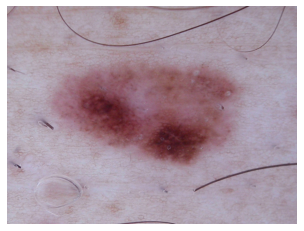

data/train/nevus/ISIC_0004363.jpeg


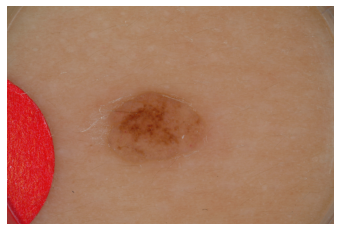

data/train/seborrheic_keratosis/ISIC_0014811.jpg


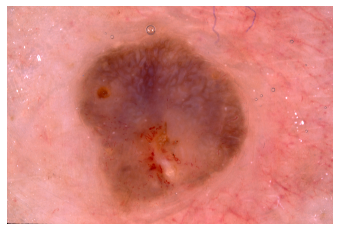

In [2]:
import os
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

### Taking a look of how a smaple image looks like

def imshow2(image):
    img = cv2.imread(image)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.axis('off')
    plt.show()

img_train_pth = "data/train/melanoma"
img_train_pth1 = "data/train/nevus"
img_train_pth2 = "data/train/seborrheic_keratosis"
sample_img = os.path.join(img_train_pth, os.listdir(img_train_pth)[0])
sample_img1 = os.path.join(img_train_pth1, os.listdir(img_train_pth1)[0])
sample_img2 = os.path.join(img_train_pth2, os.listdir(img_train_pth2)[0])

print(sample_img)
imshow2(sample_img)
print(sample_img1)
imshow2(sample_img1)
print(sample_img2)
imshow2(sample_img2)

In [3]:
def make_weights_for_balanced_classes(images, nclasses):                        
    """
    Class for balancig the image that is send to the model each batch
    """
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight   
                                         

### Image Transformation, dataset process and augmentation

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms
from collections import Counter

img_size = 224 

BALANCE_DATASET = False

pixel_normalization = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    pixel_normalization
])

valid_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    pixel_normalization
])

test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    pixel_normalization
])

train_data = datasets.ImageFolder("data/train/", transform=train_transform)
valid_data = datasets.ImageFolder("data/valid/", transform=valid_transform)
test_data = datasets.ImageFolder("data/test/", transform=test_transform)

## Shall we balance the data set by "force"   

## Force balance dataset
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = sampler, pin_memory=True) 
if BALANCE_DATASET:
    weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))                                                                
    weights = torch.DoubleTensor(weights)                                       
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = sampler, pin_memory=True)
else:
    ## Do not force balance dataset and use weight balance in the loss function
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True) 

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



### How processed data looks like

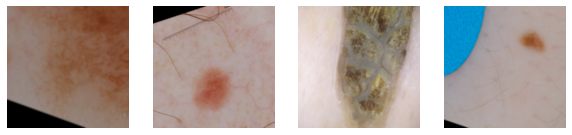

In [5]:
import numpy as np

def imshow_fromTensor(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')
    
    
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    imshow_fromTensor(images[ii], ax=ax)


### VGG16 model pretrained and fine-tuning 

In [8]:
from torchvision import models
from torch import nn
from collections import OrderedDict 

model_vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

## frezing feature layers
for param in model_vgg16.features.parameters():
    param.requires_grad = False
    
    
in_classifier_features = model_vgg16.classifier[0].in_features
n_classes = len(train_data.classes)

## Lets build the classifier part

classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_classifier_features, 1024)), 
    ("relu", nn.ReLU()),
    ("drop", nn.Dropout(0.5)),
    ("fc2", nn.Linear(1024, 256)), 
    ("relu2", nn.ReLU()),
    ("fc3", nn.Linear(256, n_classes)), 
]))

model_vgg16.classifier = classifier ## Get ride of the classifier part and and implement in our own
print(model_vgg16)

if use_cuda:
    model_vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Second Attemp, let's try with ResNet

In [17]:
from torchvision import models
from torch import nn
from collections import OrderedDict 

model_resnet = models.resnet152(pretrained=True)

in_classifier_features = model_resnet.fc.in_features
n_classes = len(train_data.classes)
#print(resnet)

## frezing feature layers
for param in model_resnet.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default

#model.fc = nn.Linear(in_features, n_classes)
classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_classifier_features, 1024)), 
    ("relu", nn.ReLU()),
    ("drop", nn.Dropout(0.3)),
    ("fc2", nn.Linear(1024, 512)), 
    ("relu2", nn.ReLU()),
    ("fc3", nn.Linear(512, n_classes)), 
]))
model_resnet.fc = classifier
print(model_resnet)

if use_cuda:
    model_resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss and optimizer

In [10]:
from torch import optim

"""
Max(Number of occurrences in most common class) / (Number of occurrences in rare classes)
In multiclass problems, if we have five classes with this number of occurrences
 
0 2021
1 2372
2 287
 
the weight value for each class is 0:(2372/2021), 1:(2372/2372), 2:(2372/287), so:
weights = [1.17, 1.0, 8.26]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
"""
if not BALANCE_DATASET:
    weights = [1.17, 1.0, 8.26]
    if use_cuda:
        class_weights = torch.FloatTensor(weights).cuda()
    else:
        class_weights = torch.FloatTensor(weights)
    criterion_entropy = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion_entropy = nn.CrossEntropyLoss()

optimizer_adam_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.001) # for vgg16
optimizer_adam_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001) # for resnet


### Training process 

In [11]:
import numpy as np
def train(n_epochs, model, training_data_loader, validation_data_loader, criterion=criterion_entropy, 
          optimizer=optimizer_adam_vgg16, use_cuda=use_cuda, save_path="model_derma.pt", valid_loss_min=np.Inf):
    
    for epoch in range(n_epochs):
        
        running_loss = 0
        valid_loss = 0
        valid_accuracy = 0        
        
        model.train()
        
        for image_batch, target_batch in training_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            optimizer.zero_grad()
            
            out = model.forward(image_batch)
            
            loss = criterion(out, target_batch)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() 
            
        train_loss = running_loss/len(train_loader)

        model.eval()
        for image_batch, target_batch in validation_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            out = model.forward(image_batch)
            
            ## Compute validation loss
            loss = criterion(out, target_batch)
            
            valid_loss += loss.item() 
            
            ## Compute validation accuracy
            top_p, top_class = out.topk(1, dim=1)
            equals = top_class == target_batch.view(*top_class.shape)                    
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        valid_loss = valid_loss/len(validation_data_loader)
        valid_accuracy = valid_accuracy/len(validation_data_loader)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValid Accuracy: {:.3f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_accuracy
        ))
        
        if valid_loss < valid_loss_min:            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model
            

### VGG training

In [ ]:
import numpy as np
model = train(50, model_vgg16, train_loader, valid_loader, save_path="model_derma2.pt", optimizer=optimizer_adam_vgg16,valid_loss_min=np.Inf)

Epoch: 0 	Training Loss: 0.969745 	Validation Loss: 0.587009 	Valid Accuracy: 0.547
Validation loss decreased (inf --> 0.587009).  Saving model ...
Epoch: 1 	Training Loss: 0.791135 	Validation Loss: 0.604673 	Valid Accuracy: 0.509
Epoch: 2 	Training Loss: 0.744886 	Validation Loss: 0.560207 	Valid Accuracy: 0.643
Validation loss decreased (0.587009 --> 0.560207).  Saving model ...
Epoch: 3 	Training Loss: 0.705460 	Validation Loss: 0.695248 	Valid Accuracy: 0.609
Epoch: 4 	Training Loss: 0.695820 	Validation Loss: 0.667517 	Valid Accuracy: 0.633
Epoch: 5 	Training Loss: 0.665522 	Validation Loss: 0.637654 	Valid Accuracy: 0.613
Epoch: 6 	Training Loss: 0.663285 	Validation Loss: 0.512665 	Valid Accuracy: 0.640
Validation loss decreased (0.560207 --> 0.512665).  Saving model ...
Epoch: 7 	Training Loss: 0.670130 	Validation Loss: 0.682454 	Valid Accuracy: 0.634
Epoch: 8 	Training Loss: 0.653960 	Validation Loss: 0.454612 	Valid Accuracy: 0.614
Validation loss decreased (0.512665 --> 0.

### Resnet Training

In [9]:
import numpy as np
model = train(20, model_resnet, train_loader, valid_loader, optimizer=optimizer_adam_resnet, save_path="model_derma_resnet2.pt")

Epoch: 0 	Training Loss: 0.683481 	Validation Loss: 0.912978 	Valid Accuracy: 0.550
Validation loss decreased (inf --> 0.912978).  Saving model ...
Epoch: 1 	Training Loss: 0.661719 	Validation Loss: 0.770287 	Valid Accuracy: 0.670
Validation loss decreased (0.912978 --> 0.770287).  Saving model ...
Epoch: 2 	Training Loss: 0.655428 	Validation Loss: 0.774138 	Valid Accuracy: 0.658
Epoch: 3 	Training Loss: 0.620605 	Validation Loss: 0.855735 	Valid Accuracy: 0.588
Epoch: 4 	Training Loss: 0.607611 	Validation Loss: 1.054323 	Valid Accuracy: 0.582
Epoch: 5 	Training Loss: 0.578446 	Validation Loss: 0.754230 	Valid Accuracy: 0.665
Validation loss decreased (0.770287 --> 0.754230).  Saving model ...
Epoch: 6 	Training Loss: 0.596865 	Validation Loss: 0.880104 	Valid Accuracy: 0.618
Epoch: 7 	Training Loss: 0.558590 	Validation Loss: 0.817796 	Valid Accuracy: 0.636
Epoch: 8 	Training Loss: 0.563286 	Validation Loss: 0.756574 	Valid Accuracy: 0.671
Epoch: 9 	Training Loss: 0.576745 	Validat

### Test Process

In [12]:
import numpy as np
def test(loader, model, criterion, use_cuda, batch_size):
    test_loss = 0.0
    class_correct = list(0. for i in range(3))
    class_total = list(0. for i in range(3))
    classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

    model.eval() # eval mode

    # iterate over test data
    for data, target in loader:
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(3):
        if class_total[i] > 0:
            print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

### Vgg16 Test

In [17]:
model_vgg16.load_state_dict(torch.load('model_derma2.pt'))
test(test_loader, model_vgg16, criterion_entropy, use_cuda, batch_size=32)

Test Loss: 0.922756

Test Accuracy of melanoma: 22% (26/117)
Test Accuracy of nevus: 20% (81/393)
Test Accuracy of seborrheic_keratosis: 96% (87/90)

Test Accuracy (Overall): 32% (194/600)


### ResNet Test

In [17]:
model_resnet.load_state_dict(torch.load('model_derma_resnet.pt'))
test(test_loader, model_resnet, criterion_entropy, use_cuda)

Test Loss: 1.057704


Test Accuracy: 49% (299/600)
